# How to pass runtime values to tools

This guide shows how to define tools that depend on dynamically defined variables. These values are provided by your program, not by the LLM.

Tools can access the [config.configurable](https://langchain-ai.github.io/langgraphjs/reference/interfaces/langgraph.LangGraphRunnableConfig.html) field for values like user IDs that are known when a graph is initially executed, as well as managed values from the [store](https://langchain-ai.github.io/langgraphjs/reference/classes/checkpoint.BaseStore.html) for persistence across threads.

However, it can be convenient to access intermediate runtime values which are not known ahead of time, but are progressively generated as a graph executes, such as the current graph state. This guide will cover two techniques for this: The `getCurrentTaskInput` utility function, and closures.

## Setup

Install the following to run this guide:

```bash
npm install @langchain/langgraph @langchain/openai @langchain/core
```
接下来，配置您的环境以连接到模型提供程序。
```bash
export OPENAI_API_KEY=your-api-key
```
或者，为 [LangSmith 追踪](https://smith.langchain.com/) 设置 API 密钥，这将为我们提供一流的可观察性。
```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```
## `getCurrentTaskInput` 实用函数

`getCurrentTaskInput` 实用程序函数可以更轻松地获取可能被间接调用的应用程序区域的当前状态，例如工具处理程序。

<div class="警告提示">
<p class="admonition-title">兼容性</p>
<p>
此功能已在 <code>@langchain/langgraph>=0.2.53</code> 中添加。
</p>
<p>
它还需要 <a href="https://nodejs.org/api/async_hooks.html"><code>async_hooks</code></a> 支持，许多流行的 JavaScript 环境（例如 Node.js、Deno 和 Cloudflare Workers）都支持该支持，但并非所有环境（主要是 Web 浏览器）都支持。如果您要部署到不支持此功能的环境，请参阅下面的 [closures](#closures) 部分。
</p>
</div>


让我们首先定义一个工具，法学硕士可以使用该工具来更新用户的宠物偏好。该工具将从当前上下文中检索图形的当前状态。

### 定义代理状态

由于我们只是跟踪消息，因此我们将使用 `MessagesAnnotation`：

In [1]:
import { MessagesAnnotation } from "@langchain/langgraph";

现在，声明一个工具，如下所示。该工具以三种不同的方式接收值：

1. 它将在其 `input` 中收到法学硕士生成的 `pets` 列表。
2. 它将拉取从初始图形调用填充的 `userId`。
3. 它将通过 `getCurrentTaskInput` 函数获取传递给当前执行任务的输入（`StateGraph` 节点处理程序，或功能 API `entrypoint` 或 `task`）。

然后它将使用 LangGraph 的[跨线程持久性](https://langchain-ai.github.io/langgraphjs/how-tos/cross-thread-persistence/) 来保存首选项：

In [2]:
import { z } from "zod";
import { tool } from "@langchain/core/tools";
import {
  getCurrentTaskInput,
  LangGraphRunnableConfig,
} from "@langchain/langgraph";

const updateFavoritePets = tool(async (input, config: LangGraphRunnableConfig) => {
  // 有些论点是由法学硕士填充的；这些包含在下面的架构中
  const { pets } = input;
  // 获取调用此工具的任务的当前输入。
  // 这将与传递到调用该工具的“ToolNode”的输入相同。
  const currentState = getCurrentTaskInput() as typeof MessagesAnnotation.State;
  // 其他信息（例如用户 ID）最容易通过配置提供
  // 这是在调用或流式传输图表时设置的
  const userId = config.configurable?.userId;
  // LangGraph 的托管键值存储也可以从配置访问
  const store = config.store;
  await store.put([userId, "pets"], "names", pets);
  // 将用户的初始输入消息存储为注释。
  // 使用相同的键将覆盖以前的值 - 你可以
  // 如果您想存储许多交互，请使用不同的东西。
  await store.put([userId, "pets"], "context", { content: currentState.messages[0].content });

  return "update_favorite_pets called.";
},
{
  // 法学硕士“看到”以下模式：
  name: "update_favorite_pets",
  description: "add to the list of favorite pets.",
  schema: z.object({
    pets: z.array(z.string()),
  }),
});

如果我们查看工具调用架构（即传递给模型进行工具调用的内容），我们可以看到仅传递了 `pets`：

In [3]:
import { zodToJsonSchema } from "zod-to-json-schema";

console.log(zodToJsonSchema(updateFavoritePets.schema));

{
  type: 'object',
  properties: { pets: { type: 'array', items: [Object] } },
  required: [ 'pets' ],
  additionalProperties: false,
  '$schema': 'http://json-schema.org/draft-07/schema#'
}


我们还声明另一个工具，以便我们的代理可以检索之前设置的首选项：

In [4]:
const getFavoritePets = tool(
  async (_, config: LangGraphRunnableConfig) => {
    const userId = config.configurable?.userId;
    // LangGraph 的托管键值存储也可以通过配置访问
    const store = config.store;
    const petNames = await store.get([userId, "pets"], "names");
    const context = await store.get([userId, "pets"], "context");
    return JSON.stringify({
      pets: petNames.value,
      context: context.value.content,
    });
  },
  {
    // 法学硕士“看到”以下模式：
    name: "get_favorite_pets",
    description: "retrieve the list of favorite pets for the given user.",
    schema: z.object({}),
  }
);

## 定义节点

从这里开始，实际上没有什么特别需要做的。这种方法适用于 `StateGraph` 和功能代理，并且与 `createReactAgent` 等预构建代理同样有效！我们将通过使用 `StateGraph` 定义自定义 ReAct 代理来演示它。这与如果您调用 [`createReactAgent`](../reference/functions/langgraph_prebuilt.createReactAgent.html) 得到的代理非常相似

让我们从定义图表的节点开始。

1. 代理：负责决定采取什么（如果有）行动。
2. 调用工具的函数：如果代理决定采取某项操作，则该节点将执行该操作。

我们还需要定义一些边。

1. 调用代理后，我们应该调用工具节点或完成。
2. 工具节点被调用后，它应该总是返回到代理来决定下一步做什么

In [5]:
import {
  END,
  START,
  StateGraph,
  MemorySaver,
  InMemoryStore,
} from "@langchain/langgraph";
import { AIMessage } from "@langchain/core/messages";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { ChatOpenAI } from "@langchain/openai";

const model = new ChatOpenAI({ model: "gpt-4o" });

const tools = [getFavoritePets, updateFavoritePets];

const routeMessage = (state: typeof MessagesAnnotation.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1] as AIMessage;
  // 如果没有调用任何工具，我们就可以完成（响应用户）
  if (!lastMessage?.tool_calls?.length) {
    return END;
  }
  // 否则，如果有，我们继续并调用工具
  return "tools";
};

const callModel = async (state: typeof MessagesAnnotation.State) => {
  const { messages } = state;
  const modelWithTools = model.bindTools(tools);
  const responseMessage = await modelWithTools.invoke([
    {
      role: "system",
      content: "You are a personal assistant. Store any preferences the user tells you about."
    },
    ...messages
  ]);
  return { messages: [responseMessage] };
};

const workflow = new StateGraph(MessagesAnnotation)
  .addNode("agent", callModel)
  .addNode("tools", new ToolNode(tools))
  .addEdge(START, "agent")
  .addConditionalEdges("agent", routeMessage)
  .addEdge("tools", "agent");

const memory = new MemorySaver();
const store = new InMemoryStore();

const graph = workflow.compile({ checkpointer: memory, store: store });

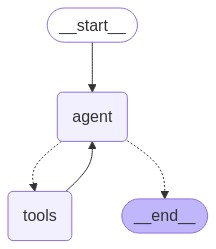

In [7]:
import * as tslab from "tslab";

const graphViz = graph.getGraph();
const image = await graphViz.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## 使用它！

现在让我们使用我们的图表！

In [8]:
import {
  BaseMessage,
  isAIMessage,
  isHumanMessage,
  isToolMessage,
  HumanMessage,
  ToolMessage,
} from "@langchain/core/messages";

let inputs = {
  messages: [ new HumanMessage({ content: "My favorite pet is a terrier. I saw a cute one on Twitter." }) ],
};

let config = {
  configurable: {
    thread_id: "1",
    userId: "a-user",
  },
};

function printMessages(messages: BaseMessage[]) {
  for (const message of messages) {
    if (isHumanMessage(message)) {
      console.log(`User: ${message.content}`);
    } else if (isAIMessage(message)) {
      const aiMessage = message as AIMessage;
      if (aiMessage.content) {
        console.log(`Assistant: ${aiMessage.content}`);
      }
      if (aiMessage.tool_calls) {
        for (const toolCall of aiMessage.tool_calls) {
          console.log(`Tool call: ${toolCall.name}(${JSON.stringify(toolCall.args)})`);
        }
      }
    } else if (isToolMessage(message)) {
      const toolMessage = message as ToolMessage;
      console.log(`${toolMessage.name} tool output: ${toolMessage.content}`);
    }
  }
}

let { messages } = await graph.invoke(inputs, config);

printMessages(messages);


User: My favorite pet is a terrier. I saw a cute one on Twitter.
Tool call: update_favorite_pets({"pets":["terrier"]})
update_favorite_pets tool output: update_favorite_pets called.
Assistant: I've added "terrier" to your list of favorite pets. If you have any more favorites, feel free to let me know!


现在验证它是否可以正确获取存储的首选项并引用它从何处获取信息：

In [9]:
inputs = { messages: [new HumanMessage({ content: "What're my favorite pets and what did I say when I told you about them?" })] };
config = {
  configurable: {
    thread_id: "2", // New thread ID, so the conversation history isn't present.
    userId: "a-user"
  }
};

messages = (await graph.invoke(inputs, config)).messages;

printMessages(messages);

User: What're my favorite pets and what did I say when I told you about them?
Tool call: get_favorite_pets({})
get_favorite_pets tool output: {"pets":["terrier"],"context":"My favorite pet is a terrier. I saw a cute one on Twitter."}
Assistant: Your favorite pet is a terrier. You mentioned, "My favorite pet is a terrier. I saw a cute one on Twitter."


正如您所看到的，代理能够正确引用该信息来自 Twitter！

## 闭包

如果您无法在环境中使用上下文变量，则可以使用闭包（https://developer.mozilla.org/en-US/docs/Web/JavaScript/Closures）来创建可以访问动态内容的工具。这是一个高级示例：

In [10]:
function generateTools(state: typeof MessagesAnnotation.State) {
  const updateFavoritePets = tool(
    async (input, config: LangGraphRunnableConfig) => {
      // 有些论点是由法学硕士填充的；这些包含在下面的架构中
      const { pets } = input;
      // 其他（例如 UserID）最好通过配置提供
      // 这是在调用或流式传输图表时设置的
      const userId = config.configurable?.userId;
      // LangGraph 的托管键值存储也可以通过配置访问
      const store = config.store;
      await store.put([userId, "pets"], "names", pets )
      await store.put([userId, "pets"], "context", {content: state.messages[0].content})

      return "update_favorite_pets called.";
    },
    {
      // 法学硕士“看到”以下模式：
      name: "update_favorite_pets",
      description: "add to the list of favorite pets.",
      schema: z.object({
        pets: z.array(z.string()),
      }),
    }
  );
  return [updateFavoritePets];
};

然后，在布局图表时，每当绑定或调用工具时，您都需要调用上述方法。例如：

In [11]:
const toolNodeWithClosure = async (state: typeof MessagesAnnotation.State) => {
  // 每当到达此节点时，我们都会获取工具
  // 形成一个闭包并让它访问最新的消息
  const tools = generateTools(state);
  const toolNodeWithConfig = new ToolNode(tools);
  return toolNodeWithConfig.invoke(state);
};